[0]	validation_0-rmse:370742.63452	validation_1-rmse:512996.11273
[100]	validation_0-rmse:206809.21242	validation_1-rmse:388494.66807
[200]	validation_0-rmse:146113.17439	validation_1-rmse:351716.32401
[287]	validation_0-rmse:115987.82843	validation_1-rmse:347513.46680
R^2: 0.5158
MAE: 204251.68 MWh/día


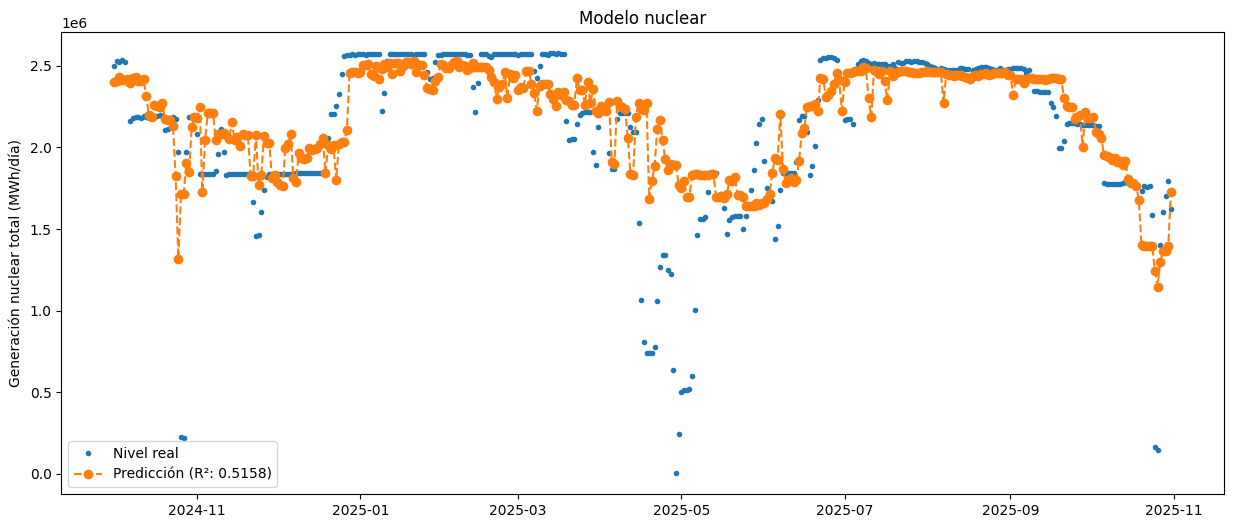

In [1]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.metrics import r2_score, mean_absolute_error
import matplotlib.pyplot as plt

DATA_PATH = '../data/2_processed/dataset_maestro_5min.parquet'
df_5min = pd.read_parquet(DATA_PATH)
df_5min = df_5min.sort_index()

agg_dict = {
    'nuc': 'sum',
    
    'temp_max_nacional_ponderada': 'first',
    'temp_min_nacional_ponderada': 'first',
    'viento_nacional_ponderado': 'first',
    'precipitacion_nacional_ponderada': 'first',

    'dia_año_sin': 'first',
    'dia_año_cos': 'first',
    'dia_semana_sin': 'first',
    'dia_semana_cos': 'first',
}

df_1d = df_5min.resample('D').agg(agg_dict)
df_1d = df_1d.rename(columns={'nuc': 'nuc_total_dia'})

df_1d['nuc_total_lag_7d'] = df_1d['nuc_total_dia'].shift(7)
df_1d['nuc_total_lag_14d'] = df_1d['nuc_total_dia'].shift(14)
df_1d['nuc_total_mean_28d'] = df_1d['nuc_total_dia'].shift(7).rolling(window=28).mean()

df_1d = df_1d.dropna() 

TARGET_NIVEL = 'nuc_total_dia'
FEATURES_NIVEL = [
    'nuc_total_lag_7d',
    'nuc_total_lag_14d',
    'nuc_total_mean_28d',

    'temp_max_nacional_ponderada',
    'temp_min_nacional_ponderada',
    'viento_nacional_ponderado',
    'precipitacion_nacional_ponderada',
    
    'dia_año_sin',
    'dia_año_cos',
    'dia_semana_sin',
    'dia_semana_cos',
]

X = df_1d[FEATURES_NIVEL]
y = df_1d[TARGET_NIVEL]

TEST_START_DATE_DIARIO = '2024-10-01'
X_train = X.loc[X.index < TEST_START_DATE_DIARIO]
y_train = y.loc[y.index < TEST_START_DATE_DIARIO]

X_test = X.loc[X.index >= TEST_START_DATE_DIARIO]
y_test = y.loc[y.index >= TEST_START_DATE_DIARIO]

model_nivel_nuc = xgb.XGBRegressor(
    n_estimators=1000,
    learning_rate=0.01,
    max_depth=6,
    objective='reg:squarederror',
    early_stopping_rounds=50,
    n_jobs=-1,
    random_state=42
)

model_nivel_nuc.fit(X_train, y_train,
                    eval_set=[(X_train, y_train), (X_test, y_test)],
                    verbose=100)

MODEL_PATH = '../models/modelo_nuc.json'
model_nivel_nuc.save_model(MODEL_PATH)

preds_nivel = model_nivel_nuc.predict(X_test)
r2_nivel = r2_score(y_test, preds_nivel)
mae = mean_absolute_error(y_test, preds_nivel)

print(f"R^2: {r2_nivel:.4f}")
print(f"MAE: {mae:.2f} MWh/día")

plt.figure(figsize=(15, 6))
plt.plot(y_test.index, y_test, label='Nivel real', marker='.', linestyle='None')
plt.plot(y_test.index, preds_nivel, label=f'Predicción (R²: {r2_nivel:.4f})', 
         linestyle='--', marker='o')
plt.title('Modelo nuclear')
plt.ylabel('Generación nuclear total (MWh/día)')
plt.legend()
plt.show()